# Profile Vacancies recommendation engine

## Context

The notebook has been created in the context of a a "Postgraduate Studies in Big Data & Analytics in Business and Management". 

It has been based on the code snippets of jalajthanaki, which created the main part of the code.
https://github.com/jalajthanaki/Job_recommendation_engine 
I modified it a bit to cater for my own dataset.



## Importing libraries

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
import os
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

## Load dataset

In [5]:
# Set the working dir
os.chdir(r'C:\Users\woutv\Jupyter\Jobs\inputdata')
# List the data
# os.listdir()

In [6]:
apps = pd.read_csv('./ProfielSolicitaties.csv', delimiter=';',encoding='utf-8')
jobs = pd.read_csv('./Vacatures.csv', delimiter=';',encoding='utf-8')
users = pd.read_csv('./ProfielenMetCV.csv' ,delimiter=';',encoding='utf-8')
# test_users = pd.read_csv('./inputdata/test_users.tsv', delimiter='\t',encoding='utf-8')

## Split training and testing data

* not used for now

In [7]:
apps_training, apps_testing = train_test_split(apps, test_size = 0.2)


## Checking some data

### Job openings based on their location information

In [8]:
jobs.groupby(['Postcode']).size().reset_index(name='Locationwise')

,Postcode,Locationwise
0,1000,59
1,1020,4
2,1030,11
3,1040,9
4,1050,21
5,1060,6
6,1070,45
7,1080,10
8,1083,9
9,1090,1


In [18]:
jobs.groupby(['Postcode']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head()

,Postcode,Locationwise
226,3900,384
191,3500,265
205,3600,201
115,2370,147
232,3960,138


In [19]:
Postal_job = jobs.groupby(['Postcode']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                             ascending=False).head(25)


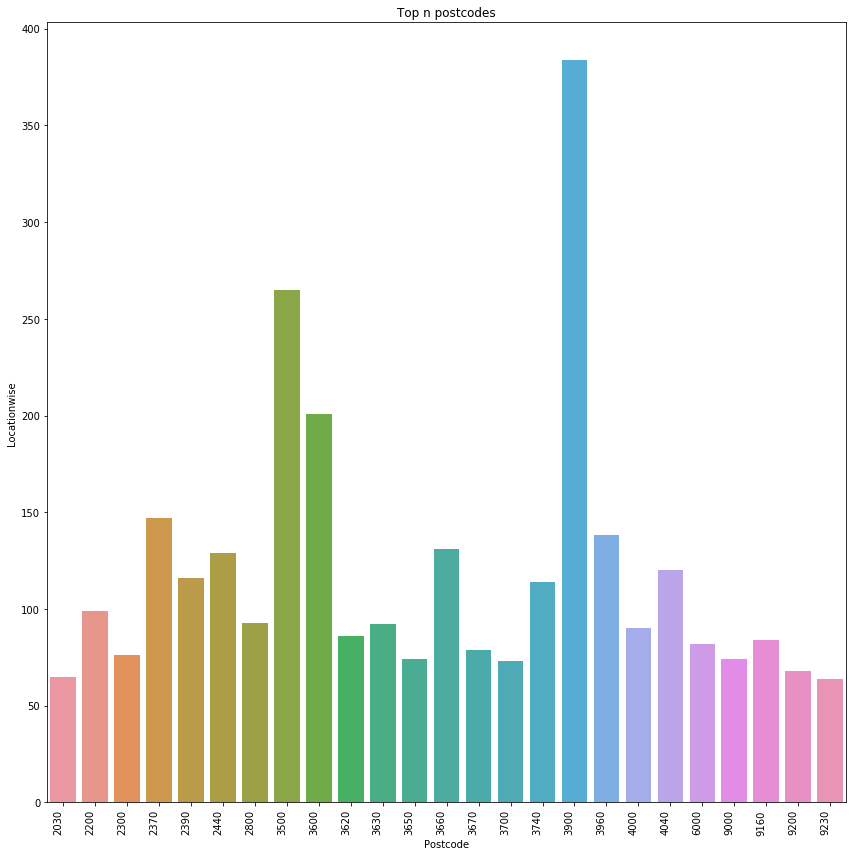

In [20]:
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Postcode", y="Locationwise", data=Postal_job)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Top n postcodes')
plt.tight_layout()
plt.show()

### Checking user profiles based on their location information

In [57]:
users.groupby(['Postcode']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                                        ascending=False).head()


,Postcode,Locationwise
395,4000,275
842,7100,198
397,4020,179
15,1070,165
343,3600,135


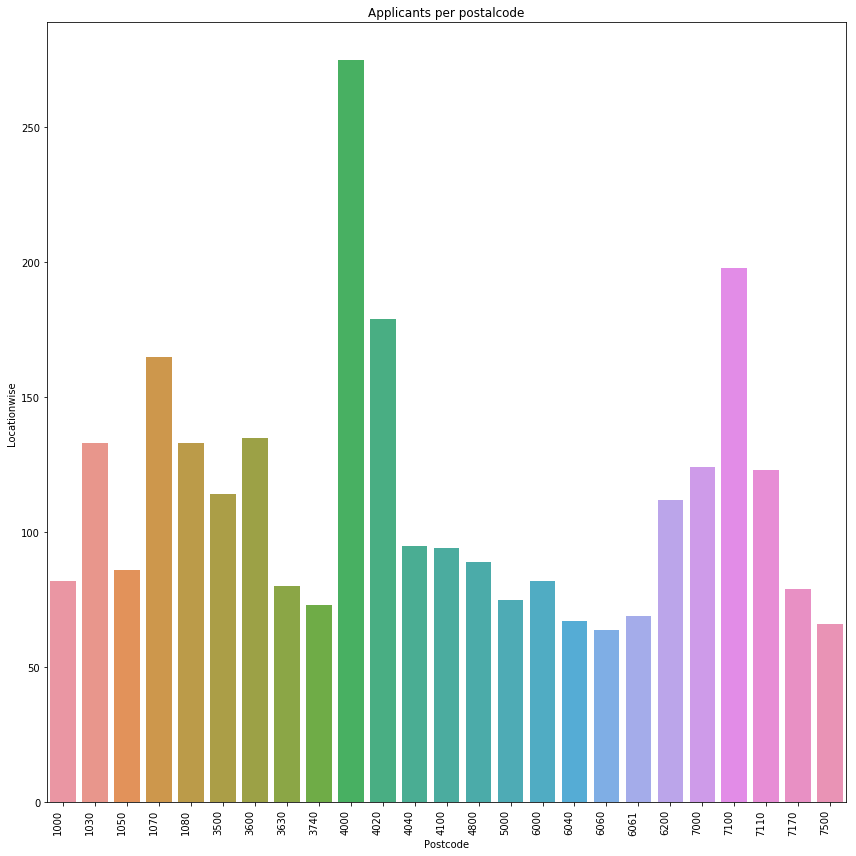

In [61]:
userspostal = users.groupby(['Postcode']).size().reset_index(name='Locationwise').sort_values('Locationwise',
                                                                                        ascending=False).head(25)
plt.figure(figsize=(12,12))
ax = sns.barplot(x="Postcode", y="Locationwise",data=userspostal)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Applicants per postalcode')
plt.tight_layout()
plt.show()

## Approach 1


###  Look for similar jobs
Simple approach to get similar jobs

In [9]:
# check the columns of the document to see with what we can work.
jobs.columns


Index(['VacatureId', 'OrgineleId', 'Naam', 'Ref', 'Datum', 'Plaats',
       'Postcode', 'Type', 'Kantoor', 'Contactpersoon', 'Contactnummer',
       'Contactemail', 'Functie', 'Takenprofiel', 'Attesten', 'Vaardigheden',
       'Opleiding', 'Vakkennis', 'Ervaring', 'Talenkennis', 'Pckennis', 'Taal',
       'Duur', 'SolicitatieTypeStatus', 'FunctiegroepId', 'Database', 'Lat',
       'Lon', 'IsDeleted', 'IngaveDatum'],
      dtype='object')

In [10]:
# Concatenate different items which are relevant.
jobs['Naam'] = jobs['Naam'].fillna('')
jobs['Functie'] = jobs['Functie'].fillna('')
jobs['Takenprofiel'] = jobs['Takenprofiel'].fillna('')
jobs['NFT'] = jobs['Naam'] + jobs['Functie'] + jobs['Takenprofiel']

In [11]:
# Remove irrelevant words
from stop_words import get_stop_words
stops_words_dutch = get_stop_words('dutch')
stops_words_french = get_stop_words('french')
stops_words_df = stops_words_dutch + stops_words_french
# print(stops_words_df)
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words=stops_words_df)

# create a matrix with the word as features (columns) and the documents as rows. The values are the Tf-idf-weights
tfidf_matrix = tf.fit_transform(jobs['NFT'])
# print (tf.get_feature_names())
tfidf_matrix

<8356x133543 sparse matrix of type '<class 'numpy.float64'>'
	with 423368 stored elements in Compressed Sparse Row format>

In [13]:
# Calculating the cosine simularity of the corpus
# A nice explanation of how this works can be found here : 
# http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [14]:
cosine_sim[0]
jobs.index

RangeIndex(start=0, stop=8356, step=1)

In [15]:
# Creating a pandas serie which will hold a list with the names of the documents and the index. This index will be used to
# retrieve the index, based on the title of the job. This in its turn is then used to lookup documents in the cosine matrix
jobs = jobs.reset_index()
titles = jobs['Naam']
indices = pd.Series(jobs.index, index=jobs['Naam'])
# print(indices)

In [16]:
def get_recommendations(title):
    if title in indices:
        idx = indices[title]
        # Create an iteratable list from the matrix and getting the row that corresponds with the document. This row 
        # contains all comparisons for this document with the rest of the documents
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        job_indices = [i[0] for i in sim_scores]
        return titles.iloc[job_indices].head(10)
    else:
        return 'Not a known vacancy'

In [17]:
get_recommendations('BATIBOUWVERKOPERS')

8349                          BATIBOUWVERKOPERS
2957                           ERVAREN VLOERDER
5698                           ERVAREN VLOERDER
6244                           ERVAREN VLOERDER
8104          INFORMANT AUTOSALON 2019 - TIENEN
8109            INFORMANT AUTOSALON 2019 - GENK
8110            INFORMANT AUTOSALON 2019 - BREE
8111    INFORMANT AUTOSALON 2019 - SINT-TRUIDEN
8103         INFORMANT AUTOSALON 2019 - WEEKEND
8106           HOSTESS AUTOSALON 2019 - WEEKEND
Name: Naam, dtype: object

In [18]:
get_recommendations('VENDEUR CONSEILLER')

8342                VENDEUR CONSEILLER
8222                VENDEUR AUTOMOBILE
1875                     VENDEUR (H/F)
2069      CONSEILLER VENDEUR OUTILLAGE
6955                      VENDEUR SHOP
424                 VENDEUR AUTOMOBILE
3178          VENDEUR AUTOMOBILE (H/F)
3833                       VENDEUR H/F
5359    CONSEILLER / VENDEUR ANIMALIER
6894    CONSEILLER / VENDEUR ANIMALIER
Name: Naam, dtype: object

In [19]:
get_recommendations('INFORMANT AUTOSALON 2019 - GENK')

8109            INFORMANT AUTOSALON 2019 - GENK
8110            INFORMANT AUTOSALON 2019 - BREE
8104          INFORMANT AUTOSALON 2019 - TIENEN
8111    INFORMANT AUTOSALON 2019 - SINT-TRUIDEN
8107    INFORMANT AUTOSALON 2019 - HERK-DE-STAD
8103         INFORMANT AUTOSALON 2019 - WEEKEND
8105         INFORMANT AUTOSALON 2019 - WEEKEND
8108         INFORMANT AUTOSALON 2019 - WEEKEND
8106           HOSTESS AUTOSALON 2019 - WEEKEND
8115                             INFORMANT (M/V
Name: Naam, dtype: object

## Approach 2

### Look for similar users
Find out similar users, based on content of the profile. Then check for which jobs they applied and present these jobs to the respective user.

In [26]:
# Only motivation contains some relevant information in the database.
users['Motivatie'] = users['Motivatie'].fillna('')
users['cvastext'] = users['cvastext'].fillna('')


In [27]:
# See above for more explanation.
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words=stops_words_df)
tfidf_matrix = tf.fit_transform(users['cvastext'])

In [28]:
tfidf_matrix.shape

(11361, 962113)

In [29]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [30]:
cosine_sim[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
users = users.reset_index()
userid = users['Id']
indices = pd.Series(users.index, index=users['Id'])

In [32]:
def get_recommendations_userwise(userid):
    idx = indices[userid]
    #print (idx)
    sim_scores = list(enumerate(cosine_sim[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return user_indices[0:11]

In [46]:
print ("-----Top 10 Similar users with userId: 5------")
get_recommendations_userwise(7)


-----Top 10 Similar users with userId: 5------


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [48]:
def get_job_id(usrid_list):
    jobs_userwise = apps['ProfielId'].isin(usrid_list) #
    df1 = pd.DataFrame(data = apps[jobs_userwise], columns=['VacatureId'])
    joblist = df1['VacatureId'].tolist()
    Job_list = jobs['VacatureId'].isin(joblist) #[1083186, 516837, 507614, 754917, 686406, 1058896, 335132])
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['Naam','Takenprofiel','Postcode'])
    return df_temp

In [69]:
# Which job did he/she apply for?
userid = 18
useridlist = [userid]
get_job_id(useridlist)

,Naam,Takenprofiel,Postcode
3195,ADMINSTRATIEF BEDIENDE - PARTTIME,Voor onze klant zijn we op zoek naar een partt...,8800
8114,CHAUFFEUR - LIVREUR,Qjobs est à la recherche d'un chauffeur livreu...,4432


In [68]:
# Which job is recommended?
get_job_id(get_recommendations_userwise(userid))

,Naam,Takenprofiel,Postcode
3134,HOOFDAANKOPER EXTERIEUR,"Taken :\n\n-Onderhandelen met leveranciers, co...",9000
3135,INPAKKER,- je werkt mee aan de inpak waar nodig\n- je c...,2520
4380,MAGASINIER CARISTE,-Vous êtes en possession de votre brevet de ca...,6061
4648,JOBSTUDENT(E) BEDIENDE,We zijn op zoek naar een gemotiveerde bediende...,3670
4757,JOBSTUDENT GROOTHANDEL GROENTEN EN FRUIT M/V (...,Voor onze klant zoeken we studenten die in de ...,3500
5632,VENDEUR SANDWICHERIE,"Faire des sandwiches, \nPrendre des commandes,...",4040
5869,VENDEUR-CONSEILLER OUTILLAGE (H/F),"Vous serez en charge d'accueillir, conseillez ...",7110
